In [18]:
import numpy as np
import pandas as pd
import scipy
import os
from sklearn import metrics
from matplotlib import pyplot as plt
import pickle
from scipy import stats
%matplotlib inline

cmap=plt.cm.tab20
cmaplist = [cmap(i) for i in range(cmap.N)]

### Load results

In [2]:
years_data = 2
only_one = False
simplify_apoe = True
COLS_TO_USE_DICT = {"demographic_cols_allyears": ['dcfdx__1.0','dcfdx__2.0', 'dcfdx__3.0', 'med_con_sum_cum', 'vasc_3dis_sum',
                            'vasc_risks_sum', 'hypertension_cum', 'cancer_cum', 'diabetes_sr_rx', 'dm_cum',
                            'headinjrloc_cum', 'thyroid_cum', 'claudication_cum', 'heart_cum', 'stroke_cum'],
"demographic_cols_oneyear": ['apoe_genotype__22.0', 'apoe_genotype__23.0', 'apoe_genotype__24.0', 'apoe_genotype__33.0', 
                            'apoe_genotype__34.0', 'apoe_genotype__44.0', 'race__1.0', 'race__2.0', 'race__3.0', 
                            'race__6.0', 'age_at_visit', 'educ', 'msex', 'spanish'],

"baseline_demographics_cols":['age_at_visit', 'educ', 'msex', 'apoe_genotype__22.0', 'apoe_genotype__23.0', 'apoe_genotype__24.0',
                              'apoe_genotype__33.0', 'apoe_genotype__34.0', 'apoe_genotype__44.0'],
"baseline_mci_cols":['dcfdx__2.0', 'dcfdx__3.0'],
"baseline_mmse30_cols":['age_at_visit', 'educ', 'msex', 'apoe_genotype__22.0', 'apoe_genotype__23.0', 'apoe_genotype__24.0',
                        'apoe_genotype__33.0', 'apoe_genotype__34.0', 'apoe_genotype__44.0', 'cts_mmse30'],
"simplified_cols":['age_at_visit', 'educ', 'msex', 'apoe_genotype__22.0', 'apoe_genotype__23.0', 'apoe_genotype__24.0',
                   'apoe_genotype__33.0', 'apoe_genotype__34.0', 'apoe_genotype__44.0', 
                   'cts_catflu', 'cts_mmse30', 'cts_sdmt', 'cts_wli', 'cts_wlii', 'cts_wliii'],
"nocogn_cols":['age_at_visit', 'educ', 'msex', 'apoe_genotype__22.0', 'apoe_genotype__23.0', 'apoe_genotype__24.0',
            'apoe_genotype__33.0', 'apoe_genotype__34.0', 'apoe_genotype__44.0', 'spanish', 
            'race__1.0', 'race__2.0', 'race__3.0', 'race__6.0', 'dcfdx__1.0', 'dcfdx__2.0',  'dcfdx__3.0', 
            'med_con_sum_cum', 'vasc_3dis_sum', 'vasc_risks_sum', 'hypertension_cum', 'cancer_cum', 'diabetes_sr_rx', 
            'dm_cum', 'headinjrloc_cum', 'thyroid_cum', 'claudication_cum', 'heart_cum', 'stroke_cum',
            'cts_animals', 'cts_bname', 'cts_catflu', 'cts_db', 'cts_delay', 'cts_df', 'cts_doperf', 'cts_ebdr', 'cts_ebmt', 
            'cts_fruits', 'cts_idea', 'cts_lopair', 'cts_mmse30', 'cts_nccrtd', 'cts_pmat', 'cts_pmsub', 'cts_read_nart', 
            'cts_sdmt', 'cts_story', 'cts_stroop_cname', 'cts_stroop_wread', 'cts_wli', 'cts_wlii', 'cts_wliii'],
"all_cols":['age_at_visit', 'educ', 'msex', 'apoe_genotype__22.0', 'apoe_genotype__23.0', 'apoe_genotype__24.0',
            'apoe_genotype__33.0', 'apoe_genotype__34.0', 'apoe_genotype__44.0', 'spanish', 
            'race__1.0', 'race__2.0', 'race__3.0', 'race__6.0', 'dcfdx__1.0', 'dcfdx__2.0',  'dcfdx__3.0', 
            'med_con_sum_cum', 'vasc_3dis_sum', 'vasc_risks_sum', 'hypertension_cum', 'cancer_cum', 'diabetes_sr_rx', 
            'dm_cum', 'headinjrloc_cum', 'thyroid_cum', 'claudication_cum', 'heart_cum', 'stroke_cum',
            'cts_animals', 'cts_bname', 'cts_catflu', 'cts_db', 'cts_delay', 'cts_df', 'cts_doperf', 'cts_ebdr', 'cts_ebmt', 
            'cts_fruits', 'cts_idea', 'cts_lopair', 'cts_mmse30', 'cts_nccrtd', 'cts_pmat', 'cts_pmsub', 'cts_read_nart', 
            'cts_sdmt', 'cts_story', 'cts_stroop_cname', 'cts_stroop_wread', 'cts_wli', 'cts_wlii', 'cts_wliii',
            'cogn_ep', 'cogn_po', 'cogn_ps', 'cogn_se', 'cogn_wo', 'cogn_global']}

# Change depending on which test you want to run
cols_name = 'nocogn_cols'
cols_to_use = COLS_TO_USE_DICT[cols_name]

In [3]:
eval_metrics = ["accuracy","roc_auc"]

years = 2
within = 3
models = ["linear", "xgb","LSTM", "MLP"]
num_years_datas =["1","2","3", "ma", "slopes"]

sample_types = ["randdownsample", "matcheddownsample", "train", "weighted"]

results_dict = {}

for model in models:
    results_dict[model] = {}
    for sample_type in sample_types:
        results_dict[model][sample_type] = {}

        for num_years_data in num_years_datas:
            res_dicts = []
            for k in range(5):

                sample_type_prefix = "" if sample_type in ["train", "weighted"] else "%s_"%sample_type
                sample_type_save = "" if sample_type=="train" else "%s_"%sample_type

                save_suffix = '%s%s_%iyrprev_within%i_yrsincluded%s'%(sample_type_save, cols_name, years, within, num_years_data)

                results_path = './results/CV/%s_%i_%s.p'%(model,k,save_suffix)


                if os.path.exists(results_path):
                    file = pickle.load(open(results_path, 'rb'))
                    res_dict = {}
                    res_dict['accuracy'], res_dict['roc_auc'], res_dict['pr_auc'], res_dict['precision'],  res_dict['recall'], res_dict['fpr'], res_dict['tpr'] = file
                    res_dicts.append(res_dict)
                    no_results = False
                else:
                    no_results = True

            results_dict[model][sample_type][num_years_data] = {}

            if no_results:
                for eval_metric in eval_metrics:
                    results_dict[model][sample_type][num_years_data][eval_metric] = np.nan

            else:
                for eval_metric in eval_metrics:
                    results_dict[model][sample_type][num_years_data][eval_metric] = np.mean([r[eval_metric] for r in res_dicts])

In [4]:
results_df = pd.DataFrame.from_dict({(i,j,k): results_dict[i][j][k]
                           for i in results_dict.keys() 
                           for j in results_dict[i].keys()
                           for k in results_dict[i][j].keys()},
                       orient='index')

In [6]:
model_names_official = {"linear": "LR", "LSTM": "LSTM", "MLP": "MLP", "xgb":"GBM"}

# appendix version
encoding_names = {"3": "All data: last 3 years", "2": "All data: last 2 years",
                  "1":"All data: current year", "ma": "Moving averages", "slopes": "Slopes"}
# main text version
sample_type_names = {"randdownsample": "Random", "matcheddownsample": "Matched pairs", "train": "Original", 
                     "weighted": "Re-weighting"}


### Generate latex tables: 

In [15]:
# main text version
for index, row in results_df.sort_values("accuracy", ascending=False).iterrows():
    model, sample_type, years_method = index
    
    # main text version
    print("%s & %s & $%.4f$ & $%.4f$ \\\\"%(model_names_official[model], encoding_names[years_method], row["accuracy"],row["roc_auc"]))


LR & All data: last 2 years & $0.9054$ & $0.9223$ \\
GBM & All data: last 3 years & $0.9046$ & $0.9163$ \\
LSTM & All data: last 2 years & $0.9045$ & $0.9197$ \\
LR & All data: last 3 years & $0.9045$ & $0.9205$ \\
LR & Slopes & $0.9045$ & $0.9204$ \\
LR & Moving averages & $0.9043$ & $0.9206$ \\
GBM & All data: current year & $0.9041$ & $0.9164$ \\
GBM & Slopes & $0.9040$ & $0.9164$ \\
MLP & All data: last 3 years & $0.9036$ & $0.9186$ \\
GBM & Moving averages & $0.9034$ & $0.9132$ \\
LR & All data: current year & $0.9032$ & $0.9229$ \\
MLP & All data: last 2 years & $0.9030$ & $0.9191$ \\
GBM & All data: last 2 years & $0.9029$ & $0.9176$ \\
LSTM & All data: current year & $0.9022$ & $0.9032$ \\
LSTM & All data: last 3 years & $0.9021$ & $0.9047$ \\
MLP & Moving averages & $0.9013$ & $0.9133$ \\
MLP & All data: current year & $0.9011$ & $0.9188$ \\
MLP & Slopes & $0.9002$ & $0.8940$ \\
LSTM & All data: last 2 years & $0.8526$ & $0.9199$ \\
GBM & All data: last 2 years & $0.8519$ & $0

### Long version

In [16]:
# appendix version

for index, row in results_df.iterrows():
    model, sample_type, years_method = index

    if (model != "LSTM") or (years_method not in ["ma", "slopes"]):
        print("%s & %s & %s & $%.4f$ & $%.4f$ \\\\"%(model_names_official[model], sample_type_names[sample_type],
                                                 encoding_names[years_method], row["accuracy"],row["roc_auc"]))


LSTM & Matched pairs & All data: current year & $0.8213$ & $0.8932$ \\
LSTM & Matched pairs & All data: last 2 years & $0.8313$ & $0.8974$ \\
LSTM & Matched pairs & All data: last 3 years & $0.8060$ & $0.8884$ \\
LSTM & Random & All data: current year & $0.8312$ & $0.9213$ \\
LSTM & Random & All data: last 2 years & $0.8315$ & $0.9188$ \\
LSTM & Random & All data: last 3 years & $0.8108$ & $0.9103$ \\
LSTM & Original & All data: current year & $0.9022$ & $0.9032$ \\
LSTM & Original & All data: last 2 years & $0.9045$ & $0.9197$ \\
LSTM & Original & All data: last 3 years & $0.9021$ & $0.9047$ \\
LSTM & Re-weighting & All data: current year & $0.8373$ & $0.9208$ \\
LSTM & Re-weighting & All data: last 2 years & $0.8526$ & $0.9199$ \\
LSTM & Re-weighting & All data: last 3 years & $0.8338$ & $0.9217$ \\
MLP & Matched pairs & All data: current year & $0.8222$ & $0.9004$ \\
MLP & Matched pairs & All data: last 2 years & $0.8154$ & $0.8822$ \\
MLP & Matched pairs & All data: last 3 years & 

### Computing performance for single years (not cumulative)

In [17]:
eval_metrics = ["accuracy","roc_auc", "pr_auc"]

years = 2
within = 3

models = ["MLP", "LSTM", "linear","xgb"]

single_years = ["yrsincluded1", "singleyear-1", "singleyear-2"]
multiple_years = ["yrsincluded1", "yrsincluded2", "yrsincluded3"]
sample_types = ["train"]


results_dict = {}
results_dict_stderrs = {}

for model in models:
    results_dict[model] = {}
    results_dict_stderrs[model] = {}

    for sample_type in sample_types:
        results_dict[model][sample_type] = {}
        results_dict_stderrs[model][sample_type] = {}

        for single_year in single_years+multiple_years:
            res_dicts = []
            for k in range(5):

                sample_type_prefix = "" if sample_type in ["train", "weighted"] else "%s_"%sample_type
                sample_type_save = "" if sample_type=="train" else "%s_"%sample_type

                save_suffix = '%s%s_%iyrprev_within%i_%s'%(sample_type_save, cols_name, years, within, single_year)

                results_path = './results/CV/%s_%i_%s.p'%(model,k,save_suffix)

                if os.path.exists(results_path):
                    file = pickle.load(open(results_path, 'rb'))
                    res_dict = {}
                    res_dict['accuracy'], res_dict['roc_auc'], res_dict['pr_auc'], res_dict['precision'],  res_dict['recall'], res_dict['fpr'], res_dict['tpr'] = file
                    res_dicts.append(res_dict)
                    no_results = False
                else:
                    no_results = True

            results_dict[model][sample_type][single_year] = {}
            results_dict_stderrs[model][sample_type][single_year] = {}

            if no_results:
                for eval_metric in eval_metrics:
                    results_dict[model][sample_type][single_year][eval_metric] = np.nan
                    results_dict_stderrs[model][sample_type][single_year][eval_metric] = np.nan

            else:
                for eval_metric in eval_metrics:
                    results_dict[model][sample_type][single_year][eval_metric] = np.mean([r[eval_metric] for r in res_dicts])
                    results_dict_stderrs[model][sample_type][single_year][eval_metric] = stats.sem([r[eval_metric] for r in res_dicts])

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

[0.901063290978735, 0.8850441940856213, 0.8789676570025604] [0, 1, 2] [array([0.0039519]), array([0.00425958]), array([0.00582344])]
[0.9021661898782838, 0.8913694490652748, 0.8732949732847726] [0, 1, 2] [array([0.00394512]), array([0.004743]), array([0.00448696])]
[0.9032407607273797, 0.8939323016936871, 0.8827584084329146] [0, 1, 2] [array([0.00383458]), array([0.00441134]), array([0.00633262])]
[0.9041234492641547, 0.8918925846693542, 0.8825348888261573] [0, 1, 2] [array([0.00472533]), array([0.00521878]), array([0.00686522])]


([<matplotlib.axis.XTick at 0x7f8eb439a9d0>,
 <a list of 3 Text xticklabel objects>)

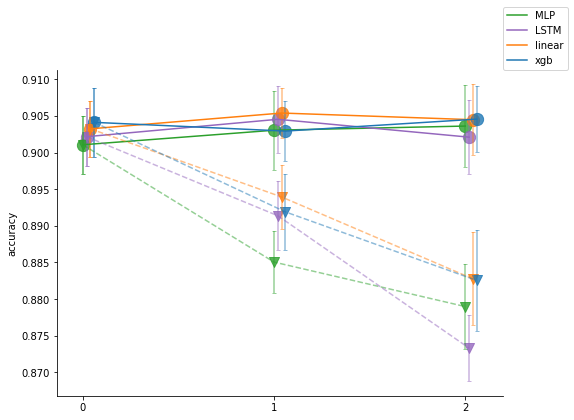

In [49]:
sample_type = "train"
eval_metric = "roc_auc"
eval_metric = "pr_auc"
eval_metric = "accuracy"

models_colors = {"MLP": cmaplist[4], "LSTM": cmaplist[8], "xgb":cmaplist[0] , "linear":cmaplist[2]}

to_plot_xs = [0,1,2]

names = ["yrsincluded1", "yrsincluded2", "yrsincluded3"]

f,ax =  plt.subplots(figsize=(8,6))
# changed size to fit in 3 plots
# f,ax =  plt.subplots(figsize=(5,7))


for modelnum, model in enumerate(models):
    to_plot_xs_forplot = [x+.02*modelnum for x in to_plot_xs]
    to_plot_ys = []
    to_plot_stderrs=[]
    for x in to_plot_xs:
        to_plot_ys.append(results_dict[model][sample_type][names[x]][eval_metric])
        to_plot_stderrs.append(results_dict_stderrs[model][sample_type][names[x]][eval_metric])

    color = models_colors[model]

    for i in range(len(to_plot_xs)):
        plt.errorbar(to_plot_xs_forplot[i], to_plot_ys[i], yerr=to_plot_stderrs[i], xerr=None, fmt='', ecolor=color, elinewidth=None, capsize=2, alpha=.5)

    plt.plot(to_plot_xs_forplot, to_plot_ys,  c=color)
    plt.scatter(to_plot_xs_forplot, to_plot_ys,  c=color, s=150, alpha=.8)

    
names = ["yrsincluded1", "singleyear-1", "singleyear-2"]


for modelnum, model in enumerate(models):
    to_plot_xs_forplot = [x+.02*modelnum for x in to_plot_xs]
    to_plot_ys = []
    to_plot_stderrs = []
    for x in to_plot_xs:
        to_plot_ys.append(results_dict[model][sample_type][names[x]][eval_metric])
        to_plot_stderrs.append(results_dict_stderrs[model][sample_type][names[x]][eval_metric])

    print(to_plot_ys, to_plot_xs, to_plot_stderrs)
    
    color = models_colors[model]

    plt.plot(to_plot_xs_forplot, to_plot_ys, alpha=.5, linestyle="--", c=color)
    plt.scatter(to_plot_xs_forplot, to_plot_ys, marker="v",  c=color, s=100, alpha=.8)

    for i in range(len(to_plot_xs_forplot)):
        plt.errorbar(to_plot_xs_forplot[i], to_plot_ys[i], yerr=to_plot_stderrs[i], xerr=None, fmt='', ecolor=color, elinewidth=None, capsize=2, alpha=.5)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_facecolor("None")

plt.legend(models, loc=(1,1))
plt.ylabel(eval_metric)
plt.xticks(to_plot_xs)